# IMDB Film Duygu Analizi

In [1]:
conda install -c anaconda py-xgboost

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


## Kütüphanelerin Import Edilmesi

In [19]:
import os
import math
import nltk
import scipy
import string
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.stats import randint
from wordcloud import WordCloud
from multiprocessing import Pool
from nltk.corpus import stopwords
from scipy.stats import loguniform

from sklearn.decomposition import PCA
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')



## Veri Setinin Import Edilmesi

In [4]:
df = pd.read_csv('/Users/isakulaksiz/Desktop/SentimentAn/movie.csv', header=0)
target = 'label'
df.reset_index(drop=True, inplace=True)
original_df = df.copy(deep=True)
display(df.head(10))

print('\n\033[1mSonuç:\033[0m Veri setinde {} özellik & {} örnek.'.format(df.shape[1], df.shape[0]))

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
5,A terrible movie as everyone has said. What ma...,0
6,Finally watched this shocking movie last night...,1
7,I caught this film on AZN on cable. It sounded...,0
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1



Sonuç: Veri setinde 2 özellik & 40000 örnek.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


# Veri Ön İşleme

In [6]:
print(df.isnull().sum())

text     0
label    0
dtype: int64


In [7]:
counter = 0
r,c = original_df.shape

df1 = df.drop_duplicates()
df1.reset_index(drop=True, inplace=True)

if df1.shape==(r,c):
    print('\n\033[1mSonuç:\033[0m Veri setinde tekrar yoktur!')
else:
    print(f'\n\033[1mSonuç:\033[0m Tekrarlanan veri kaldırılan/düzeltilen ---> {r-df1.shape[0]}')


Sonuç: Tekrarlanan veri kaldırılan/düzeltilen ---> 277


In [8]:
import nltk
import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

df = df1.copy()

def preprocessor(text):
    text = text.lower()
    text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
    text = ' '.join([PorterStemmer().stem(word) for word in text.split()])
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

for i in tqdm(range(df.shape[0])):
    df.loc[i,'text'] = preprocessor(df['text'][i])


df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/isakulaksiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|█████████████████████████████████████| 39723/39723 [12:37<00:00, 52.41it/s]


,text,label
0,grew b watch love thunderbird mate school watc...,0
1,put thi movi dvd player sat coke chip expect w...,0
2,whi peopl know particular time past wa like fe...,0
3,even though great interest biblic movi wa bore...,0
4,im die hard dad armi fan noth ever chang got t...,1


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
porter=PorterStemmer()
def tokenizer(text):
        return text.split()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tfidf=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm='l2',smooth_idf=True)
y=df.label.values
x=tfidf.fit_transform(df.text)

## Basic EDA

                Etiketlerin Dağılımı               


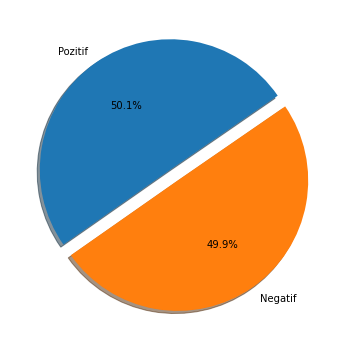

In [10]:
print('\033[1mEtiketlerin Dağılımı'.center(55))
plt.pie(df[target].value_counts(), labels=['Pozitif','Negatif'], counterclock=False, shadow=True, 
        explode=[0,0.1], autopct='%1.1f%%', radius=1, startangle=215)
plt.show()

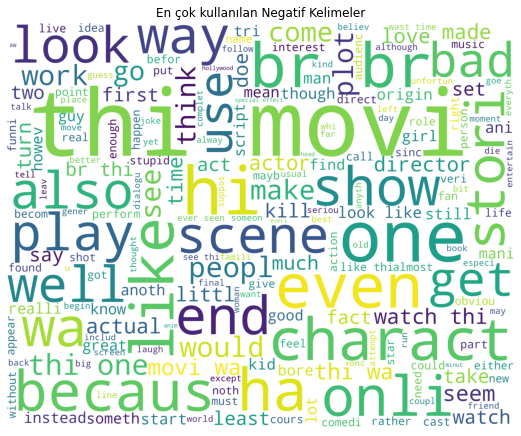

In [11]:
negdata = df[df['label']== 0]
negdata= negdata['text']

def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

plt.figure(figsize=[20,10])

plt.subplot(1,2,2)
wordcloud_draw(negdata, 'white','En çok kullanılan Negatif Kelimeler')
plt.show()

# Model Oluşturma

In [12]:
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=0)

print('Veri Seti  ---> ',X.shape,Y.shape,'\nEğitim seti  ---> ',Train_X.shape,Train_Y.shape,'\nTest seti   ---> ', Test_X.shape,'', Test_Y.shape)

Veri Seti  --->  (39723, 1) (39723,) 
Eğitim seti  --->  (31778, 119535) (31778,) 
Test seti   --->  (7945, 119535)  (7945,)


In [13]:
LR_model = LogisticRegression()
LR = LR_model.fit(Train_X, Train_Y)
pred = LR.predict(Test_X)
pred_prob = LR.predict_proba(Test_X)
print("Accuracy: "+str(accuracy_score(Test_Y, pred)))
print("Precision: "+str(precision_score(Test_Y, pred)))
print("Recall: "+str(recall_score(Test_Y, pred)))
print("F1-score: "+str(f1_score(Test_Y, pred)))
print()
print("Confusion Matrix: ")
print(confusion_matrix(Test_Y, pred))
print()
print(classification_report(Test_Y, pred))


Accuracy: 0.8908747640025173
Precision: 0.8748122183274912
Recall: 0.904946904946905
F1-score: 0.8896244430299172

Confusion Matrix: 
[[3584  500]
 [ 367 3494]]

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      4084
           1       0.87      0.90      0.89      3861

    accuracy                           0.89      7945
   macro avg       0.89      0.89      0.89      7945
weighted avg       0.89      0.89      0.89      7945



In [14]:
def AUC_ROC_plot(Test_Y, pred):    
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2))) 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

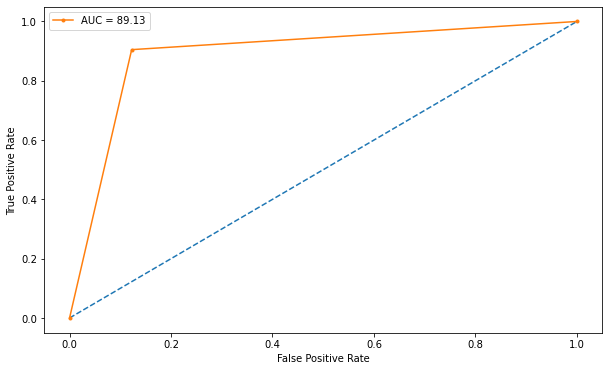

In [15]:
AUC_ROC_plot(Test_Y,pred)

In [20]:
NB_model = BernoulliNB()
NB = NB_model.fit(Train_X, Train_Y)
pred = NB.predict(Test_X)
pred_prob = NB.predict_proba(Test_X)
print("Accuracy: "+str(accuracy_score(Test_Y, pred)))
print("Precision: "+str(precision_score(Test_Y, pred)))
print("Recall: "+str(recall_score(Test_Y, pred)))
print("F1-score: "+str(f1_score(Test_Y, pred)))
print()
print("Confusion Matrix: ")
print(confusion_matrix(Test_Y, pred))
print()
print(classification_report(Test_Y, pred))

Accuracy: 0.8453115166771554
Precision: 0.8611416026344676
Recall: 0.8127428127428128
F1-score: 0.836242504996669

Confusion Matrix: 
[[3578  506]
 [ 723 3138]]

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      4084
           1       0.86      0.81      0.84      3861

    accuracy                           0.85      7945
   macro avg       0.85      0.84      0.84      7945
weighted avg       0.85      0.85      0.85      7945



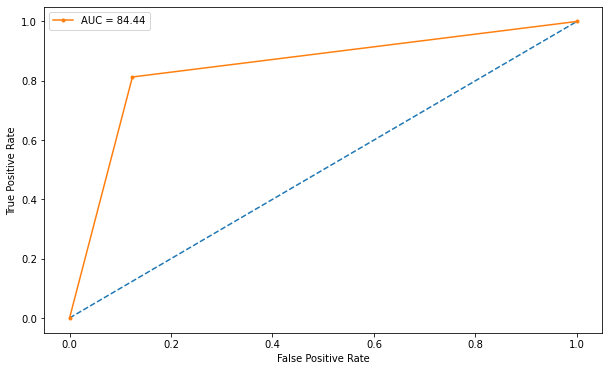

In [21]:
AUC_ROC_plot(Test_Y,pred)